In [1]:
import pandas as pd
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### Loading the data 

In [2]:
data = pd.read_csv('Data/data.csv')
pd.set_option('display.max_columns', None)
data.shape

(119011, 34)

In [18]:
data.tail()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,PLAYER_AST,PLAYER_WEIGHT,DEFENDER_OREB,DEFENDER_DREB,DEFENDER_STL,DEFENDER_BLK,DEFENDER_WEIGHT
119006,21400175,"NOV 21, 2014 - MIL @ TOR",A,L,-42,3,4,8:55,15.2,0,0.8,22.9,3,missed,BRUNO CABOCLO,203998,10.6,0,0,JARED DUDLEY,201162,197.5,202.5,7.2,46.8,38.5,71.6,1.8,101.25,0.1,0.1,0.0,0.1,98.10
119007,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,3,3,1:35,3.3,1,2.4,6.7,2,made,JULIUS RANDLE,203944,5.3,1,2,KOSTAS PAPANIKOLAOU,203123,200.0,202.5,4.2,35.0,29.2,72.2,2.0,101.25,0.0,0.0,0.0,0.0,112.50
119008,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,2,2,10:10,24.0,0,0.3,4.1,2,made,JULIUS RANDLE,203944,3.2,1,2,DWIGHT HOWARD,2730,207.5,202.5,15.8,59.3,50.0,52.8,1.2,119.25,0.0,0.0,0.0,0.0,112.50
119009,21400744,"FEB 05, 2015 - SAC vs. DAL",H,L,-23,9,4,3:21,13.3,5,5.4,21.9,2,missed,RICKY LEDO,203495,5.0,0,0,NIK STAUSKAS,203917,195.0,201.0,4.4,36.5,32.2,85.9,0.9,92.25,0.9,1.2,0.4,0.1,88.00
119010,21400498,"JAN 03, 2015 - MIN vs. UTA",H,L,-12,7,4,0:26,2.6,1,0.7,4.3,2,made,TOURE' MURRY,203315,2.8,1,2,ANTHONY BENNETT,203461,200.0,192.5,5.2,42.1,30.4,64.1,0.8,110.25,0.2,0.0,0.2,0.0,87.75


In [61]:
data.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'PLAYER_NAME', 'PLAYER_ID', 'PLAYER_HEIGHT',
       'DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
       'PLAYER_FT%', 'PLAYER_AST', 'PLAYER_WEIGHT', 'DEFENDER_OREB',
       'DEFENDER_DREB', 'DEFENDER_STL', 'DEFENDER_BLK', 'DEFENDER_WEIGHT'],
      dtype=object)

### Manipulating the data

In [3]:
# separate data into matrix of predictor variables and vector of target variables
names = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
         'DRIBBLES', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
         'PLAYER_HEIGHT','DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
          'PLAYER_FT%','DEFENDER_STL', 'DEFENDER_BLK', 'SHOT_RESULT']

# converting data to usable numerical data
# todo: move this to preprocessing 
def convert_time(time_string):
    time = time_string.split(':')
    return float(time[0])*60 + float(time[1])

# convert game_clock to seconds
data['GAME_CLOCK'] = data['GAME_CLOCK'].apply(lambda x: convert_time(x))

# convert shot_result to either 0 or 1
data['SHOT_RESULT'] = (data['SHOT_RESULT'] == 'made').astype(int)
# convert win to either 0 

# encode categorical data 
data_encoded = pd.get_dummies(data[names])

# split into train and test set with roughly 75-25 split
train, test = train_test_split(data_encoded, test_size=0.25)
Xtrain = train.drop(['SHOT_RESULT'], axis=1)
ytrain = train['SHOT_RESULT']
Xtest = test.drop(['SHOT_RESULT'], axis=1)
ytest = test['SHOT_RESULT']

### Setting the baseline

First baseline we consider is to predict every shot within 5 feet of the basket as a make and anything else as a miss. 

In [4]:
yhat = (Xtest['SHOT_DIST'] <= 5).astype(int)
acc = np.mean(yhat == ytest)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.608376


A more complex baseline we can try is to use k-nn algorithm. First, we need to normalize the data so that no one parameter exerts more influence on the result than others. 

In [5]:
# without normalizing data 
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [6]:
yhat_ts = neigh.predict(Xtest)
acc = np.mean(ytest.values == yhat_ts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.632810


In [7]:
# with normaliziation 
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_norm = scaler.transform(Xtrain)
scaler.fit(Xtest)
Xtest_norm = scaler.transform(Xtest)

neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain_norm,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [8]:
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.999933


In [9]:
# finding out why the accuracy is so high 
Xtrain[Xtrain['FGM'] >= 1]

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H
63399,14,3,41.0,15.0,9,3.2,2,2.4,1,2,182.5,207.5,17.3,38.5,30.4,82.7,0.4,2.0,0,1
85368,8,3,276.0,9.0,3,5.5,2,1.4,1,2,190.0,207.5,10.0,41.2,37.0,81.3,1.0,2.2,1,0
24254,1,1,677.0,17.1,0,2.9,2,1.0,1,2,207.5,210.0,13.8,51.4,0.0,38.9,0.4,1.2,0,1
91011,14,4,136.0,1.1,0,22.3,3,5.0,1,3,187.5,197.5,12.0,43.9,26.7,88.1,0.8,0.4,1,0
97448,6,3,279.0,12.1,0,3.2,2,6.9,1,2,210.0,210.0,6.3,56.3,0.0,52.4,0.8,0.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,6,3,273.0,17.7,0,13.9,2,2.7,1,2,182.5,200.0,15.5,40.4,34.0,86.1,0.4,0.1,1,0
81425,8,2,261.0,8.0,3,18.6,2,3.7,1,2,180.0,182.5,19.1,48.5,39.8,90.0,1.3,0.2,0,1
13014,11,3,491.0,11.0,3,18.1,2,5.4,1,2,197.5,195.0,21.7,46.3,43.9,87.9,0.8,0.2,1,0
60620,10,3,708.0,12.5,0,1.4,2,3.5,1,2,200.0,202.5,19.2,44.5,36.4,81.2,0.7,0.4,1,0


In [10]:
# FGM is not the total field goals made, but whether or not that 
# individual shot was made or not, so we need to drop this 
Xtrain_new = Xtrain.drop(['FGM','PTS'], axis=1)
Xtest_new = Xtest.drop(['FGM', 'PTS'], axis=1)
scaler_new = StandardScaler()
scaler_new.fit(Xtrain_new)
Xtrain_norm_new = scaler_new.transform(Xtrain_new)
scaler_new.fit(Xtest_new)
Xtest_norm_new = scaler_new.transform(Xtest_new)

In [11]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [12]:
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.576816


In [13]:
# trying different k's
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 10: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=30)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 30: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 50: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 100: {0:f}'.format(acc))

Accuracy for k = 10: 0.566901
Accuracy for k = 30: 0.582361
Accuracy for k = 50: 0.590058
Accuracy for k = 100: 0.597889


Accuracy increases as k increases but the increases get smaller as k gets larger and larger. Let's try manually assigning weights to normalized features now and transforming features 

### Visualizing relationship between features and output

The goal is to see if there are trends between the features and the outcome. This is so we can manually input some weights for the KNN method to increase the baseline accuracy

In [27]:
y = ytrain.values
make = (y==1)
miss = (y==0)

def plot_cnt(X,y,labels,ylim=None,xlim=None,start=0,end=-1):
    
    # add random "jitter" to seperate points
    var = .15;
    Xnew = X[start:end]
    makenew = make[start:end]
    missnew= miss[start:end]
    Xj = Xnew + var*np.random.randn(Xnew.shape[0],Xnew.shape[1]) 

    # Create the scatter plot
    plt.plot(Xj[makenew,0],Xj[makenew,1],'b.')
    plt.plot(Xj[missnew,0],Xj[missnew,1],'g.')
    plt.xlabel(labels[0], fontsize=16)
    plt.ylabel(labels[1], fontsize=16)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend(['make','miss'],loc='upper right')
    return plt

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

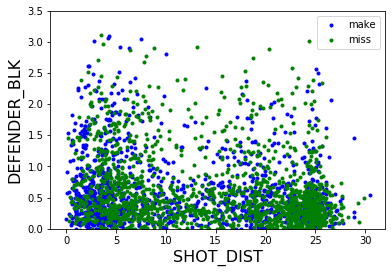

In [157]:
xnames1 = ['SHOT_DIST', 'DEFENDER_BLK']
X1 = Xtrain[xnames1].values

plot_cnt(X1,y,xnames1,ylim=(0,3.5),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

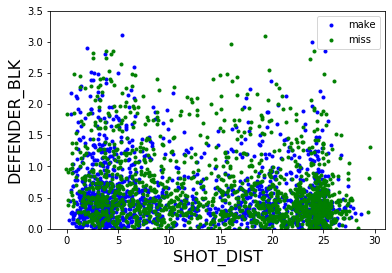

In [158]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

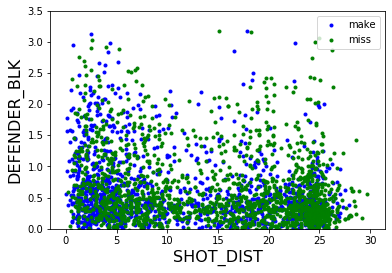

In [141]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=6000,end=9000)

There seems to be a dense region of made shots around higher shot distance and lower BPG of the closest defender and more missed shots closer to the rim. Just to note, defensive stats such as BPG are not always great indicators of a player's defensive ability. 

In [109]:
xnames2 = ['SHOT_DIST', 'CLOSE_DEF_DIST']
X2 = Xtrain[xnames2].values

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

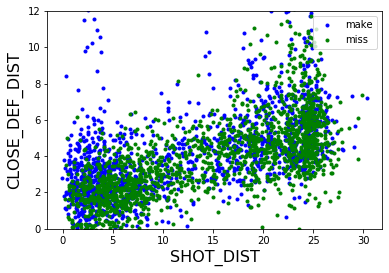

In [133]:
plot_cnt(X2,y,xnames2,ylim=(0,12),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

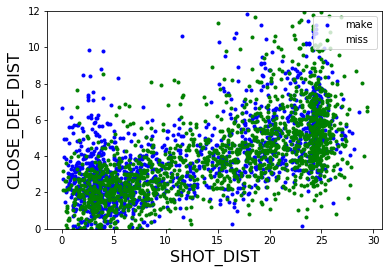

In [134]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

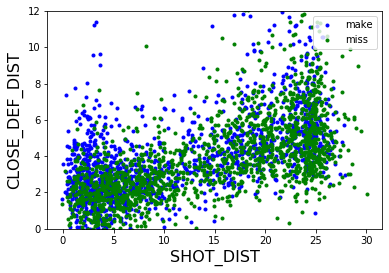

In [136]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

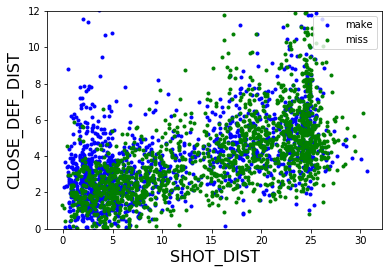

In [137]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=9000,end=12000)

Similar to the relationship between shot distance and distance of the closest defender, there seems to be less missed shots the further away we get from the rim, even if the closest defender is pretty close. It seems that shots at the rim are easier to contest than jump shots, given the nature of how each shot is attempted.

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

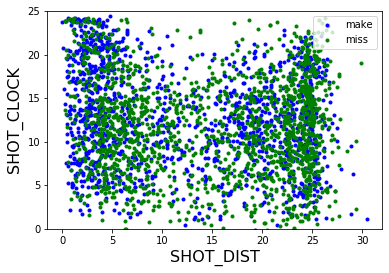

In [138]:
xnames3 = ['SHOT_DIST', 'SHOT_CLOCK']
X3 = Xtrain[xnames3].values

plot_cnt(X3,y,xnames3,ylim=(0,25),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

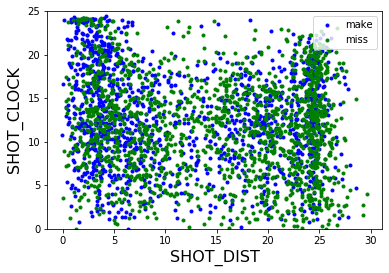

In [142]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

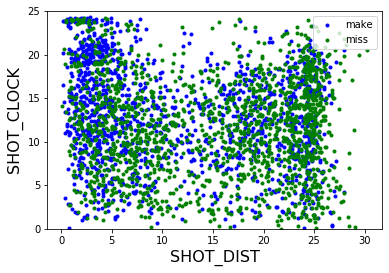

In [143]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

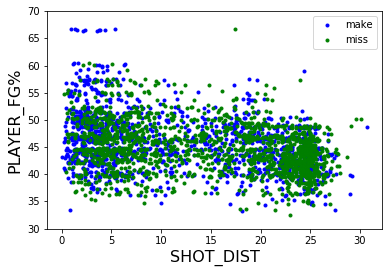

In [161]:
xnames4 = ['SHOT_DIST', 'PLAYER_FG%']
X4 = Xtrain[xnames4].values

plot_cnt(X4,y,labels=xnames4,ylim=(30,70),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

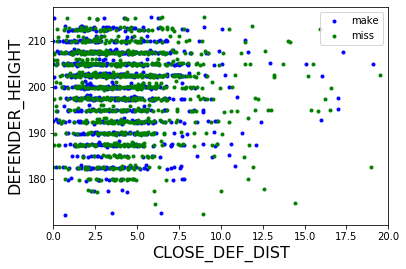

In [30]:
xnames5 = ['CLOSE_DEF_DIST', 'DEFENDER_HEIGHT']
X5 = Xtrain[xnames5].values

plot_cnt(X5,y,xnames5,xlim=(0,20),end=2000)

In [14]:
# feature transformations
Xtrain_new['SHOT_DST/DEF_BLKS'] = \
    Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

Xtest_new['SHOT_DST/DEF_BLKS'] = \
    Xtest_new['SHOT_DIST']/Xtest_new['DEFENDER_BLK']

In [15]:
Xtrain_new[Xtrain_new['SHOT_DST/DEF_BLKS'] == np.inf]

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
103139,11,4,661.0,18.1,0,5.8,2,0.6,192.5,192.5,15.8,39.6,32.7,90.1,0.5,0.0,0,1,inf
8127,5,4,473.0,13.5,6,9.0,2,2.6,195.0,180.0,7.4,44.3,34.8,81.2,0.6,0.0,1,0,inf
15939,5,3,612.0,3.5,0,27.4,3,2.6,182.5,185.0,15.8,44.6,38.6,85.9,0.6,0.0,0,1,inf
20949,17,4,453.0,19.5,7,4.4,2,2.0,195.0,187.5,13.5,48.9,39.2,71.7,0.4,0.0,0,1,inf
115488,3,2,611.0,20.5,0,24.6,3,8.0,200.0,200.0,13.4,46.7,40.7,85.9,0.1,0.0,0,1,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24916,4,4,633.0,2.2,0,3.1,2,2.8,202.5,185.0,4.0,45.9,0.0,63.2,0.3,0.0,1,0,inf
15833,15,4,353.0,14.6,3,8.3,2,1.8,187.5,185.0,23.8,48.7,44.3,91.4,0.6,0.0,0,1,inf
16084,11,4,100.0,12.0,0,23.9,3,11.0,182.5,180.0,6.7,38.9,32.1,89.2,0.5,0.0,1,0,inf
53019,14,3,361.0,20.8,1,4.0,2,3.1,192.5,187.5,27.4,44.0,37.5,86.8,1.2,0.0,0,1,inf


In [16]:
Xtrain_new = Xtrain_new.replace([np.inf, -np.inf],0)
Xtest_new = Xtest_new.replace([np.inf, -np.inf],0)

In [17]:
Xtrain_new

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
103139,11,4,661.0,18.1,0,5.8,2,0.6,192.5,192.5,15.8,39.6,32.7,90.1,0.5,0.0,0,1,0.000000
63399,14,3,41.0,15.0,9,3.2,2,2.4,182.5,207.5,17.3,38.5,30.4,82.7,0.4,2.0,0,1,1.600000
85368,8,3,276.0,9.0,3,5.5,2,1.4,190.0,207.5,10.0,41.2,37.0,81.3,1.0,2.2,1,0,2.500000
84769,14,3,234.0,3.7,0,24.5,3,4.7,207.5,210.0,21.1,46.0,37.5,77.2,0.6,1.7,0,1,14.411765
95827,8,2,81.0,16.0,10,10.5,2,1.1,187.5,182.5,23.8,48.7,44.3,91.4,1.6,0.2,1,0,52.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71571,1,1,433.0,24.0,0,25.1,3,1.8,200.0,207.5,9.9,39.5,30.7,58.9,1.1,0.5,1,0,50.200000
37792,7,2,81.0,19.0,0,0.7,2,3.1,200.0,205.0,10.6,50.4,28.1,79.0,0.7,0.7,0,1,1.000000
75556,1,1,113.0,2.4,2,19.3,2,3.9,205.0,207.5,10.2,40.5,31.6,80.3,0.9,1.0,1,0,19.300000
21960,1,1,169.0,20.3,1,24.3,3,11.3,182.5,195.0,6.7,38.9,32.1,89.2,0.3,0.2,1,0,121.500000


In [18]:
scaler_new = StandardScaler()
scaler_new.fit(Xtrain_new)
Xtrain_norm_new = scaler_new.transform(Xtrain_new)
scaler_new.fit(Xtest_new)
Xtest_norm_new = scaler_new.transform(Xtest_new)

In [21]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [22]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

Accuracy: 0.599536


Very small increase in accuracy. Let's manually add weights. These weights are a guess on how much a certain feature will play into determining whether a shot is a miss or make. This is just from years of watching and playing basketball. 

In [31]:
# increase weight of player PPG by 5 
Xtrain_norm_new[:,10] = Xtrain_norm_new[:,10] * 5

# increase weight of player FG% by 5
Xtrain_norm_new[:,11] = Xtrain_norm_new[:,11] * 5

# increase weight of player 3P% by 2
Xtrain_norm_new[:,12] = Xtrain_norm_new[:,12] * 2

# increase weight of closest defender distance by 3
Xtrain_norm_new[:,7] = Xtrain_norm_new[:,7] * 3

# increase weight of shot distance by 2
Xtrain_norm_new[:,5] = Xtrain_norm_new[:,5] * 2

In [35]:
# do the same for Xtest
Xtest_norm_new[:,10] = Xtest_norm_new[:,10] * 5
Xtest_norm_new[:,11] = Xtest_norm_new[:,11] * 5
Xtest_norm_new[:,12] = Xtest_norm_new[:,12] * 2
Xtest_norm_new[:,7] = Xtest_norm_new[:,7] * 3
Xtest_norm_new[:,5] = Xtest_norm_new[:,5] * 2

In [33]:
Xtrain_norm_new[0]

array([ 0.9687525 ,  1.34377293,  1.48381983,  1.01612429, -0.59265219,
       -1.78791448, -0.5985648 , -3.87642236, -0.54544799, -0.7309785 ,
        2.53472621, -5.57887814,  0.3846621 ,  1.43494902, -0.73641057,
       -1.04450595, -1.00136776,  1.00136776, -0.81891992])

In [36]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [ ]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

reweight parameters 
try different number of neighbors
feature transformation 
- ratio of shot distance to shot defender, etc
- do we keep the original features 
try logistic regression 
 

In [163]:
Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

87225      24.500000
69569       1.166667
76866     115.000000
66704       6.375000
48933      26.857143
             ...    
117551     22.000000
16978      82.333333
69479       4.666667
106629      2.000000
41346       8.666667
Length: 89258, dtype: float64

(6, 1.0)

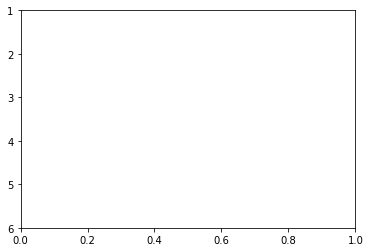

In [154]:
plt.ylim(6)